In [1]:
import os, glob, random

import numpy as np
import pandas as pd

import umap
import phate

from scipy.spatial import distance
from scipy.signal import savgol_filter

from gtda.diagrams import BettiCurve
from gtda.plotting import plot_diagram
from gtda.homology import VietorisRipsPersistence

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt

#### TDA helper methods

In [2]:
def compute_norm_betti_persistence_curve(barcode, step, curve_max):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    totalpoints = len(barcode)
    
    for i in linetraverse:
        value = 0
        for(a,b) in barcode:
            if((a < i) & (b > i)):
                value = value + 1
        curvvalues.append(value/totalpoints)
        
    return (linetraverse, curvvalues)

#### Plot by cell type

In [3]:
cell_type = "Iba1"
dim = 0
disp_persdiag = False
color_dict = {"0D":"indigo", "5D":"darkred", "15D":"darkgreen", "30D":"gold"}

M21	30D	66938 cells	18965 sampled 	 (28.33%)
M39	0D	30904 cells	15216 sampled 	 (49.24%)
M12	5D	74216 cells	17555 sampled 	 (23.65%)
M36	15D	92221 cells	19602 sampled 	 (21.26%)
M02	30D	53429 cells	18583 sampled 	 (34.78%)
M16	15D	75989 cells	15946 sampled 	 (20.98%)
M05	30D	69097 cells	17802 sampled 	 (25.76%)
M23	15D	83964 cells	16328 sampled 	 (19.45%)
M25	30D	102220 cells	19952 sampled 	 (19.52%)
M43	0D	66567 cells	20153 sampled 	 (30.27%)
M15	5D	114970 cells	20535 sampled 	 (17.86%)
M34	15D	65850 cells	16869 sampled 	 (25.62%)
M14	30D	51091 cells	15278 sampled 	 (29.9%)
M42	0D	53817 cells	18547 sampled 	 (34.46%)
M30	5D	82579 cells	18811 sampled 	 (22.78%)
M11	5D	71421 cells	16152 sampled 	 (22.62%)
M41	0D	64140 cells	17263 sampled 	 (26.91%)
M09	15D	74601 cells	17860 sampled 	 (23.94%)
M24	15D	93466 cells	17659 sampled 	 (18.89%)
M20	30D	63992 cells	18825 sampled 	 (29.42%)
M27	30D	62588 cells	14804 sampled 	 (23.65%)
M40	0D	77955 cells	18514 sampled 	 (23.75%)
M04	15D	99166 cell

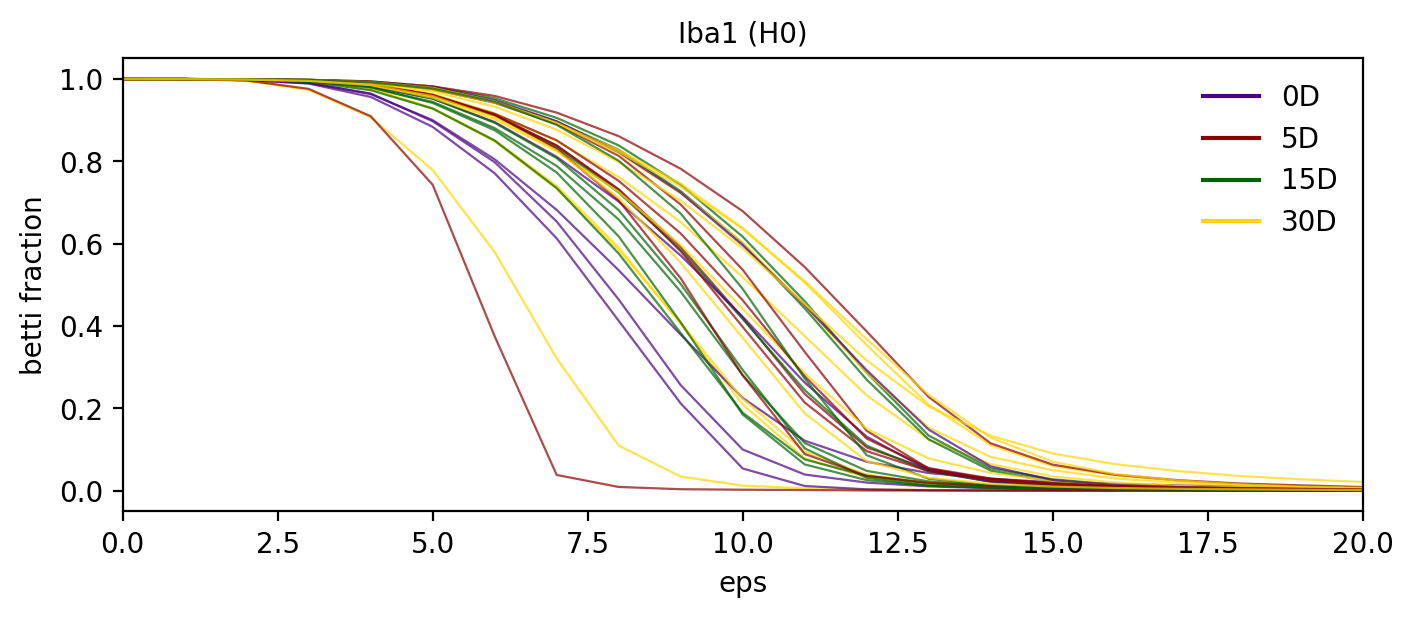

In [4]:
plt.figure(figsize=(8,3), dpi=200)

for csvfname in glob.glob(os.path.join("data", cell_type, "*.csv")):
    
    fname_parts = os.path.splitext(os.path.basename(csvfname))[0].split("_")
    ctype = fname_parts[-1]
    dpi = fname_parts[-2]
    mid = fname_parts[-3]
    
    df = pd.read_csv(csvfname)
    
    #tda = np.load(os.path.join("results_npy", cell_type, mid+"_"+dpi+"_"+cell_type+".npy"), allow_pickle=True).item()
    try:
        tda = np.load(os.path.join("results_npy", mid+"_"+dpi+"_TDA.npy"), allow_pickle=True).item()
    except:
        continue
    
    totcells = df.shape[0]
    
    dict_ctype_key = cell_type
    if cell_type == "Iba1":
        dict_ctype_key = "Iba"   
    
    nsampled = tda[dict_ctype_key+"_ptcloud"].shape[0]
    
    betti_curve = tda[dict_ctype_key+"_bc"][0][dim]
    
    if disp_persdiag:
        idx = tda[dict_ctype_key+"_dgm"][:,2] == dim
        if dim == 0:
            ax = plt.gca()
            parts = ax.violinplot(tda[dict_ctype_key+"_dgm"][idx,1]/nsampled, showmeans=False, showmedians=False, 
                                  showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor("none")
                pc.set_edgecolor(color_dict[dpi])
                pc.set_alpha(0.7)
        else:
            plt.scatter(tda[dict_ctype_key+"_dgm"][idx,0], tda[dict_ctype_key+"_dgm"][idx,1], s=0.2, alpha=0.7, color=color_dict[dpi])
    else:
        plt.plot(betti_curve/nsampled, linewidth=0.8, alpha=0.7, color=color_dict[dpi])
    
    print(mid + "\t" + dpi + "\t" + str(totcells) + " cells\t" + str(nsampled) + 
          " sampled \t (" + str(np.round(nsampled*100/totcells, 2)) + "%)")
    
plt.plot(np.NaN, np.NaN, '-', color="indigo", label="0D")
plt.plot(np.NaN, np.NaN, '-', color="darkred", label="5D")
plt.plot(np.NaN, np.NaN, '-', color="darkgreen", label="15D")
plt.plot(np.NaN, np.NaN, '-', color="gold", label="30D")

if disp_persdiag:
    if dim == 0:
        plt.xticks([])
        plt.ylabel("log(Interval End)", fontsize=10)
        plt.yscale("log")
    else:
        plt.xlabel("Interval Start", fontsize=10)
        plt.ylabel("Interval End", fontsize=10)
else:
    plt.xlabel("eps", fontsize=10)
    plt.ylabel("betti fraction", fontsize=10)
    
    
plt.title(cell_type + " (H" + str(dim) + ")", fontsize=10)
leg = plt.legend(frameon=False)
plt.xlim(0,20)
leg.get_frame().set_facecolor("none")
plt.show()

#### DPI Classification

In [53]:
cell_types = ["Iba1", "NeuN", "Gfap"]
dim = "H0p1"

In [54]:
X = []
y = []

for cell_type in cell_types:

    for csvfname in glob.glob(os.path.join("data", cell_type, "*.csv")):

        fname_parts = os.path.splitext(os.path.basename(csvfname))[0].split("_")
        ctype = fname_parts[-1]
        dpi = fname_parts[-2]
        mid = fname_parts[-3]

        df = pd.read_csv(csvfname)
        
        #tda = np.load(os.path.join("results", cell_type, mid+"_"+dpi+"_"+cell_type+".npy"), allow_pickle=True).item()
        try:
            tda = np.load(os.path.join("results_npy", mid+"_"+dpi+"_TDA.npy"), allow_pickle=True).item()
        except:
            continue

        y.append(dpi)
        
        dict_ctype_key = cell_type
        if cell_type == "Iba1":
            dict_ctype_key = "Iba"   
    
        totcells = df.shape[0]
        nsampled = tda[dict_ctype_key+"_ptcloud"].shape[0]

        if dim == "H0":
            betti_curve = tda[dict_ctype_key+"_bc"][0][0]
        elif dim == "H1":
            betti_curve = tda[dict_ctype_key+"_bc"][0][1]
        elif dim == "H0p1":
            betti_curve = np.hstack([tda[dict_ctype_key+"_bc"][0][0], tda[dict_ctype_key+"_bc"][0][1]])
        else:
            print("Error: Unknown TDA feature")

        X.append(betti_curve)

/home/labmember/anaconda2/envs/py38/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Prediction acc: 0.7777777777777778


/home/labmember/anaconda2/envs/py38/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


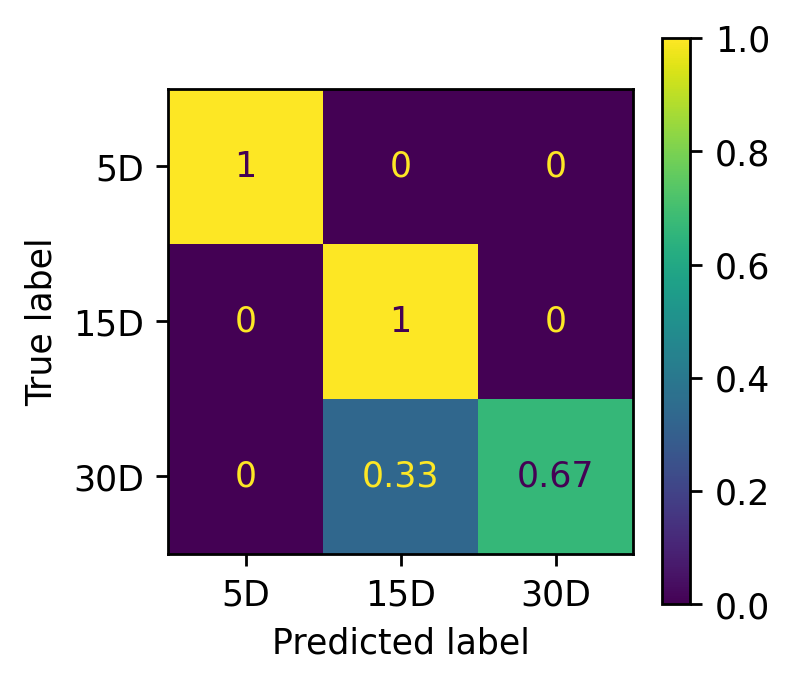

In [58]:
X = np.array(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

y = np.array(y)

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=2)
for i, (train_index, test_index) in enumerate(ss.split(X_pca, y)):
    if i == 0:
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        y_train = y[train_index]
        y_test = y[test_index]

clf = RandomForestClassifier(max_depth=50, random_state=1573)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Prediction acc: {acc}")

plt.figure(figsize=(3,3), dpi=250)
plot_confusion_matrix(clf, X_test, y_test, ax=plt.gca(), normalize='true', labels=["5D","15D","30D"])  
plt.show()

#### Cell type Classification

In [65]:
cell_types = ["Iba1", "NeuN", "Gfap"]
selected_dpi = "15D"
dim = "H0p1"

In [66]:
X = []
y = []

for cell_type in cell_types:

    for csvfname in glob.glob(os.path.join("data", cell_type, "*.csv")):

        fname_parts = os.path.splitext(os.path.basename(csvfname))[0].split("_")
        ctype = fname_parts[-1]
        dpi = fname_parts[-2]
        mid = fname_parts[-3]
        
        if dpi == selected_dpi:

            df = pd.read_csv(csvfname)
            #tda = np.load(os.path.join("results", cell_type, mid+"_"+dpi+"_"+cell_type+".npy"), allow_pickle=True).item()
            try:
                tda = np.load(os.path.join("results_npy", mid+"_"+dpi+"_TDA.npy"), allow_pickle=True).item()
            except:
                continue
            
            y.append(ctype)
            
            dict_ctype_key = cell_type
            if cell_type == "Iba1":
                dict_ctype_key = "Iba" 

            totcells = df.shape[0]
            nsampled = tda[dict_ctype_key+"_ptcloud"].shape[0]

            if dim == "H0":
                betti_curve = tda[dict_ctype_key+"_bc"][0][0]
            elif dim == "H1":
                betti_curve = tda[dict_ctype_key+"_bc"][0][1]
            elif dim == "H0p1":
                betti_curve = np.hstack([tda[dict_ctype_key+"_bc"][0][0], tda[dict_ctype_key+"_bc"][0][1]])
            else:
                print("Error: Unknown TDA feature")

            X.append(betti_curve)

Prediction acc: 1.0


/home/labmember/anaconda2/envs/py38/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


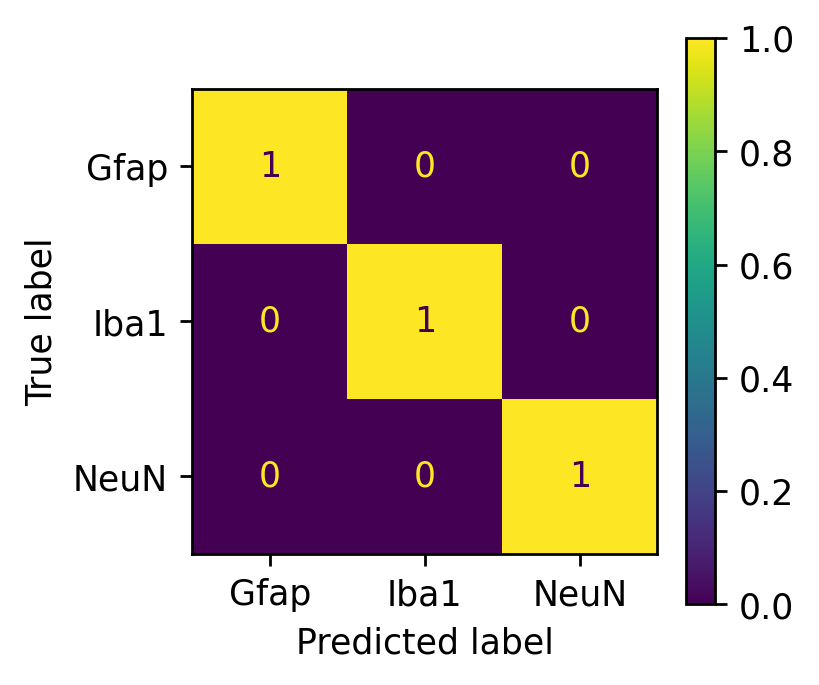

In [67]:
X = np.array(X)
y = np.array(y)

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for i, (train_index, test_index) in enumerate(ss.split(X, y)):
    if i == 0:
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        y_train = y[train_index]
        y_test = y[test_index]

clf = RandomForestClassifier(max_depth=10, random_state=37)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Prediction acc: {acc}")

plt.figure(figsize=(3,3), dpi=250)
plot_confusion_matrix(clf, X_test, y_test, ax=plt.gca(), normalize='true')  
plt.show()

#### Plot by DPI

In [52]:
days_post_injury = 30
dim = 0
disp_persdiag = False
px2um = 1.3
color_dict = {"NeuN":"darkred", "Gfap":"darkgreen", "Iba1":"indigo"}

M21	Iba1	66938 cells	18965 sampled 	 (28.33%)
M02	Iba1	53429 cells	18583 sampled 	 (34.78%)
M05	Iba1	69097 cells	17802 sampled 	 (25.76%)
M25	Iba1	102220 cells	19952 sampled 	 (19.52%)
M14	Iba1	51091 cells	15278 sampled 	 (29.9%)
M20	Iba1	63992 cells	18825 sampled 	 (29.42%)
M27	Iba1	62588 cells	14804 sampled 	 (23.65%)
M32	Iba1	54516 cells	16127 sampled 	 (29.58%)
M35	Iba1	41244 cells	15484 sampled 	 (37.54%)
M10	Iba1	80852 cells	18640 sampled 	 (23.05%)
M35	NeuN	222568 cells	15484 sampled 	 (6.96%)
M27	NeuN	213799 cells	14804 sampled 	 (6.92%)
M02	NeuN	230386 cells	18583 sampled 	 (8.07%)
M20	NeuN	213813 cells	18825 sampled 	 (8.8%)
M21	NeuN	267052 cells	18965 sampled 	 (7.1%)
M05	NeuN	193123 cells	17802 sampled 	 (9.22%)
M25	NeuN	280038 cells	19952 sampled 	 (7.12%)
M10	NeuN	208674 cells	18640 sampled 	 (8.93%)
M14	NeuN	191347 cells	15278 sampled 	 (7.98%)
M32	NeuN	173734 cells	16127 sampled 	 (9.28%)
M21	Gfap	153760 cells	18965 sampled 	 (12.33%)
M32	Gfap	120237 cells	16127 sampled

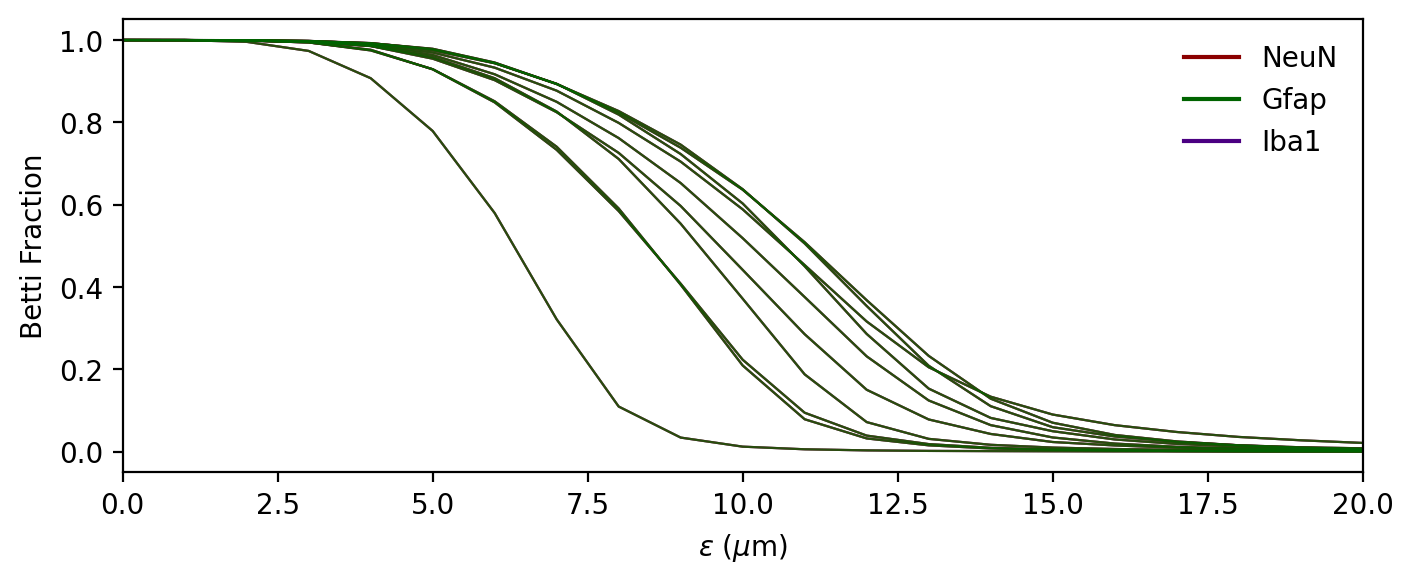

In [53]:
X = []
y = []
clr = []

plt.figure(figsize=(8,3), dpi=200)

for csvfname in glob.glob(os.path.join("data", "*", "*.csv")):
    
    fname_parts = os.path.splitext(os.path.basename(csvfname))[0].split("_")
    ctype = fname_parts[-1]
    dpi = fname_parts[-2]
    mid = fname_parts[-3]
    
    if int(dpi[:-1]) == days_post_injury:
        
        df = pd.read_csv(csvfname)
        
        #tda = np.load(os.path.join("results", ctype, mid+"_"+dpi+"_"+ctype+".npy"), allow_pickle=True).item()
        
        try:
            tda = np.load(os.path.join("results_npy", mid+"_"+dpi+"_TDA.npy"), allow_pickle=True).item()
        except:
            continue
            
        dict_ctype_key = cell_type
        if cell_type == "Iba1":
            dict_ctype_key = "Iba"   
    
        totcells = df.shape[0]
        nsampled = tda[dict_ctype_key+"_ptcloud"].shape[0]

        print(mid + "\t" + ctype + "\t" + str(totcells) + " cells\t" + str(nsampled) + 
          " sampled \t (" + str(np.round(nsampled*100/totcells, 2)) + "%)")
        
        betti_curve = px2um*tda[dict_ctype_key+"_bc"][0][dim]
        
        X.append(betti_curve)
        y.append(mid + " (" + ctype + ")")
        clr.append(color_dict[ctype])

        if disp_persdiag:
            idx = tda["dgm"][:,2] == dim
            if dim == 0:
                ax = plt.gca()
                parts = ax.violinplot(tda[dict_ctype_key+"_dgm"][idx,1], showmeans=False, showmedians=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor("none")
                    pc.set_edgecolor(color_dict[ctype])
                    pc.set_alpha(0.7)
            else:
                plt.scatter(tda[dict_ctype_key+"_dgm"][idx,0], tda[dict_ctype_key+"_dgm"][idx,1], s=0.2, alpha=0.7, color=color_dict[ctype])
        else:
            plt.plot(betti_curve/np.max(betti_curve), linewidth=0.8, alpha=0.7, color=color_dict[ctype])
            
plt.plot(np.NaN, np.NaN, '-', color="darkred", label="NeuN")
plt.plot(np.NaN, np.NaN, '-', color="darkgreen", label="Gfap")
plt.plot(np.NaN, np.NaN, '-', color="indigo", label="Iba1")

if disp_persdiag:
    if dim == 0:
        plt.xticks([])
        plt.ylabel("log(Interval End)", fontsize=10)
        plt.yscale("log")
    else:
        plt.xlabel("Interval Start", fontsize=10)
        plt.ylabel("Interval End", fontsize=10)
else:
    plt.xlabel(r"$\epsilon$ ($\mu$m)", fontsize=10)
    plt.ylabel("Betti Fraction", fontsize=10)
    
#plt.title(str(days_post_injury) + " DPI (H" + str(dim) + ")", fontsize=10)
leg = plt.legend(frameon=False)
plt.xlim(0,20)
leg.get_frame().set_facecolor("none")
plt.show()

In [54]:
X = np.array(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [55]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)

In [56]:
phate_op = phate.PHATE()
X_phate = phate_op.fit_transform(X)

Calculating PHATE...
  Running PHATE on 30 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 20
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/home/labmember/anaconda2/envs/py38/lib/python3.9/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 30 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


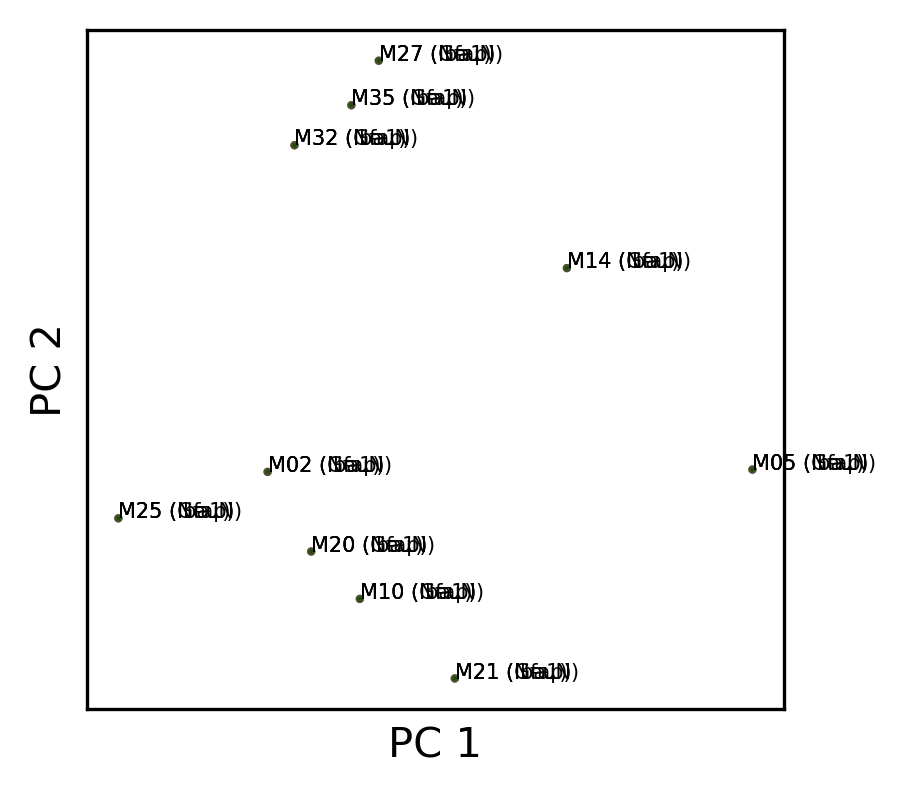

In [57]:
plt.figure(figsize=(3,3), dpi=300)
plt.scatter(X_pca[:,0], X_pca[:,1], c=clr, s=1, alpha=0.5)
num_pts = int(X_pca.shape[0])
for i in range(num_pts):
    plt.text(X_pca[i,0]+0.5, X_pca[i,1]+0.5, y[i], fontsize=5)
plt.xticks([])
plt.yticks([])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

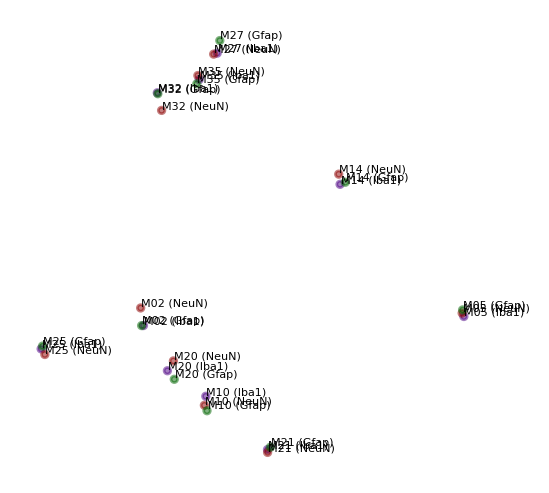

In [58]:
num_pts = int(X_pca.shape[0])
jitter = np.random.uniform(low=1700, high=2500, size=(num_pts,2))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(X_pca[:,0]+jitter[:,0], X_pca[:,1]+jitter[:,1], c=clr, s=5.5, alpha=0.5)

for i in range(num_pts):
    plt.text(X_pca[i,0]+jitter[i,0]+50, X_pca[i,1]+jitter[i,1]+50, y[i], fontsize=4)
plt.xticks([])
plt.yticks([])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.axis("off")
plt.show()

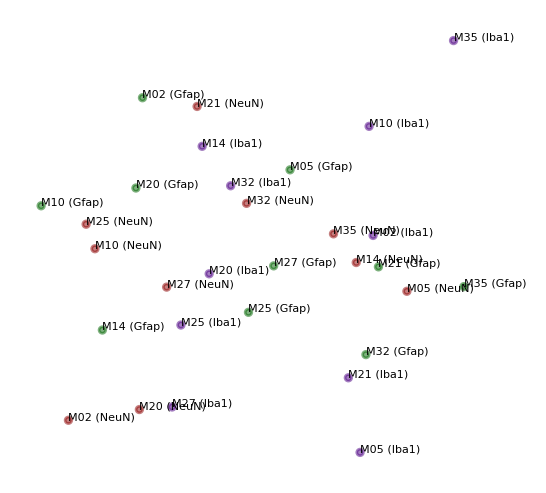

In [59]:
num_pts = int(X_pca.shape[0])
jitter = np.random.uniform(low=1, high=2, size=(num_pts,2))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(X_phate[:,0]+jitter[:,0], X_phate[:,1]+jitter[:,1], c=clr, s=5.5, alpha=0.5)

for i in range(num_pts):
    plt.text(X_phate[i,0]+jitter[i,0], X_phate[i,1]+jitter[i,1], y[i], fontsize=4)
    
plt.xticks([])
plt.yticks([])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.axis("off")
plt.show()

### Embeddings distance versus time

In [71]:
data = {}
    
for csvfname in glob.glob(os.path.join("data", "*", "*.csv")):

    fname_parts = os.path.splitext(os.path.basename(csvfname))[0].split("_")
    ctype = fname_parts[-1]
    dpi = fname_parts[-2]
    mid = fname_parts[-3]

    df = pd.read_csv(csvfname)
    #tda = np.load(os.path.join("results", ctype, mid+"_"+dpi+"_"+ctype+".npy"), allow_pickle=True).item()
    
    try:
        tda = np.load(os.path.join("results_npy", mid+"_"+dpi+"_TDA.npy"), allow_pickle=True).item()
    except:
        continue
    
    dict_ctype_key = ctype
    if ctype == "Iba1":
        dict_ctype_key = "Iba" 

    totcells = df.shape[0]
    nsampled = tda[dict_ctype_key+"_ptcloud"].shape[0]

    betti_curve = px2um*tda[dict_ctype_key+"_bc"][0][dim]

    data[dpi,mid,ctype] = betti_curve

/home/labmember/anaconda2/envs/py38/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [72]:
X = []
mid = []
dpi = []
ctype = []

for ii, (d, m, c) in enumerate(data.keys()):
    
    dpi.append(d)
    mid.append(m)
    ctype.append(c)
    X.append(data[d,m,c])
    
X = np.array(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

data_transformed = dict()

for ii, d in enumerate(dpi):
    
    data_transformed[d,mid[ii],ctype[ii]] = (X_pca[ii,0], X_pca[ii,1])

In [73]:
dpis = ["0D", "5D", "15D", "30D"]
mice_by_dpi = {}
for dpi in dpis:
    mice = [tup[1] for tup in data_transformed.keys() if tup[0]==dpi]
    mice_by_dpi[dpi] = np.unique(mice)

In [74]:
IbaNeuNmean = []
IbaGfapmean = []
NeuNGfapmean = []

IbaNeuNstd = []
IbaGfapstd = []
NeuNGfapstd = []

for dpi in dpis:
    
    mice = mice_by_dpi[dpi]
    IbaNeuNdist = []
    IbaGfapdist = []
    NeuNGfapdist = []
    
    for mouse in mice:
        
        IbaNeuNdist.append(distance.euclidean(data_transformed[dpi,mouse,"Iba1"],
                                             data_transformed[dpi,mouse,"NeuN"]))
        IbaGfapdist.append(distance.euclidean(data_transformed[dpi,mouse,"Iba1"],
                                             data_transformed[dpi,mouse,"Gfap"]))
        NeuNGfapdist.append(distance.euclidean(data_transformed[dpi,mouse,"NeuN"],
                                             data_transformed[dpi,mouse,"Gfap"]))
        
    IbaNeuNmean.append(np.mean(IbaNeuNdist))
    IbaNeuNstd.append(np.std(IbaNeuNdist))
    
    IbaGfapmean.append(np.mean(IbaGfapdist))
    IbaGfapstd.append(np.std(IbaGfapdist))
    
    NeuNGfapmean.append(np.mean(NeuNGfapdist))
    NeuNGfapstd.append(np.std(NeuNGfapdist))

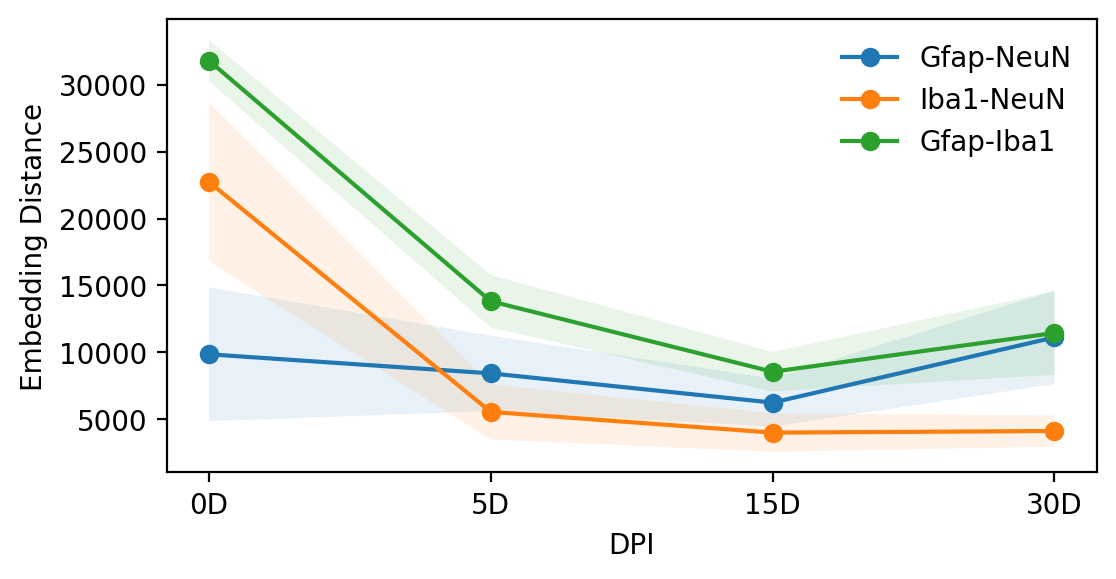

In [110]:
plt.figure(figsize=(6,3), dpi=200)
plt.plot(IbaNeuNmean, '-o', label="Gfap-NeuN")
plt.plot(IbaGfapmean, '-o',label="Iba1-NeuN")
plt.plot(NeuNGfapmean, '-o', label="Gfap-Iba1")

plt.fill_between([0,1,2,3], np.array(IbaNeuNmean)-0.5*np.array(IbaNeuNstd), 
                 np.array(IbaNeuNmean)+0.5*np.array(IbaNeuNstd), alpha=0.1)

plt.fill_between([0,1,2,3], np.array(IbaGfapmean)-0.5*np.array(IbaGfapstd), 
                 np.array(IbaGfapmean)+0.5*np.array(IbaGfapstd), alpha=0.1)

plt.fill_between([0,1,2,3], np.array(NeuNGfapmean)-0.5*np.array(NeuNGfapstd), 
                 np.array(NeuNGfapmean)+0.5*np.array(NeuNGfapstd), alpha=0.1)

plt.xticks([0,1,2,3], labels=dpis)
plt.ylabel("Embedding Distance")
plt.xlabel("DPI")
plt.legend(loc=1, frameon=False)
plt.show()

#### Plot by mouse ID

In [119]:
mouse_id = 16
px2um = 1.3

disp_persdiag = False
plt_H0 = False
plt_H1 = True
plt_pairs = False

color_dict = {"NeuN":"darkred", "Gfap":"darkgreen", "Iba1":"indigo",
             "Iba_Gfap":"violet", "Iba_NeuN":"magenta", "Gfap_NeuN":"gold",
             "Iba_Gfap_NeuN": "darkgray"}

15D	Iba1	75989 cells	15946 sampled 	 (20.98%)
15D	NeuN	164501 cells	12268 sampled 	 (7.46%)
15D	Gfap	158494 cells	15721 sampled 	 (9.92%)


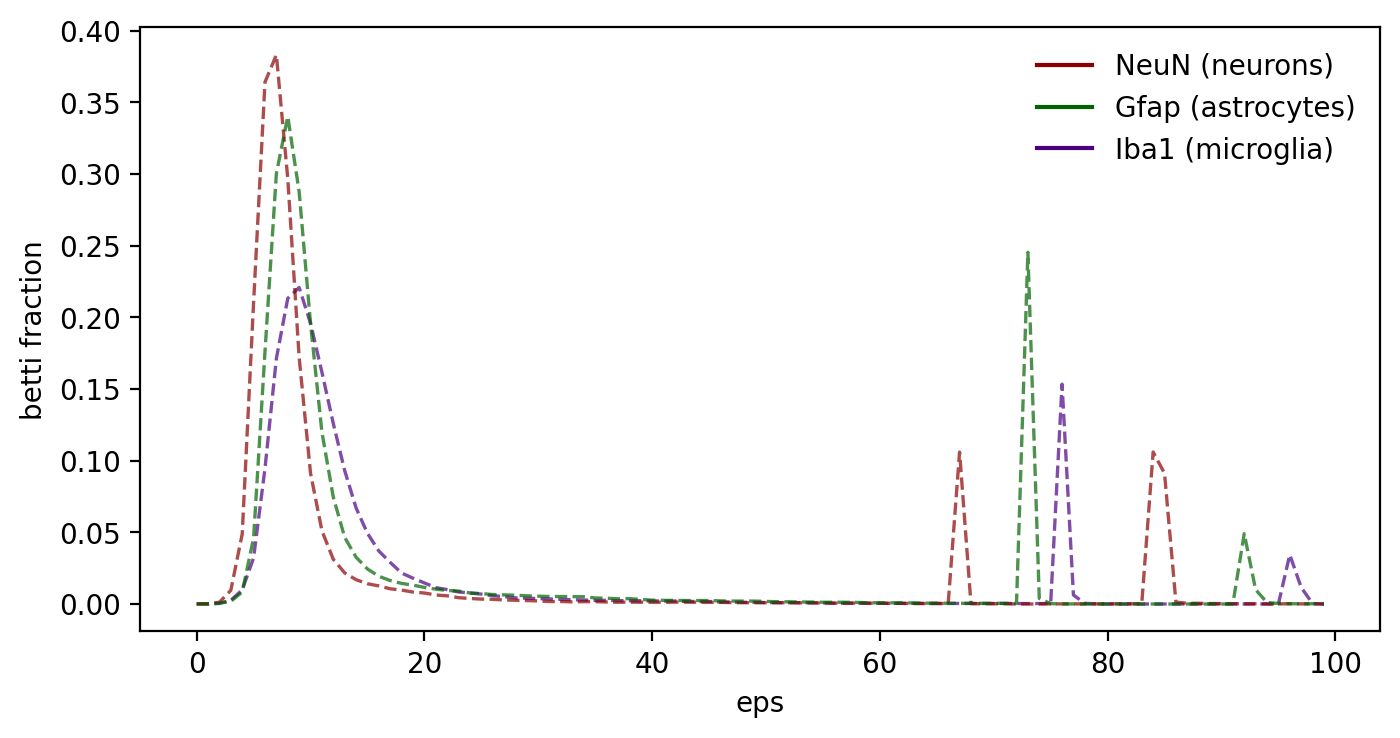

In [120]:
plt.figure(figsize=(8,4), dpi=200)

for csvfname in glob.glob(os.path.join("data", "*", "*.csv")):
    
    fname_parts = os.path.splitext(os.path.basename(csvfname))[0].split("_")
    ctype = fname_parts[-1]
    dpi = fname_parts[-2]
    mid = fname_parts[-3]
    
    if int(mid[1:]) == mouse_id:
        
        df = pd.read_csv(csvfname)
        
        #tda = np.load(os.path.join("results", ctype, mid+"_"+dpi+"_"+ctype+".npy"), allow_pickle=True).item()
        
        try:
            tda = np.load(os.path.join("results_npy", mid+"_"+dpi+"_TDA.npy"), allow_pickle=True).item()
        except:
            continue

        dict_ctype_key = ctype
        if ctype == "Iba1":
            dict_ctype_key = "Iba"

        totcells = df.shape[0]
        nsampled = tda[dict_ctype_key+"_ptcloud"].shape[0]
        
        print(dpi + "\t" + ctype + "\t" + str(totcells) + " cells\t" + str(nsampled) + 
          " sampled \t (" + str(np.round(nsampled*100/totcells, 2)) + "%)")

        if disp_persdiag:
            if plt_H0:
                idx = tda["dgm"][:,2] == 0
                plt.scatter(px2um*tda[dict_ctype_key+"_dgm"][idx,0], px2um*tda[dict_ctype_key+"_dgm"][idx,1], s=0.2, alpha=0.7, 
                            color=color_dict[ctype])
            if plt_H1:
                idx = tda[dict_ctype_key+"_dgm"][:,2] == 1
                plt.scatter(px2um*tda[dict_ctype_key+"_dgm"][idx,0], px2um*tda[dict_ctype_key+"_dgm"][idx,1], s=0.2, alpha=0.7, 
                            color=color_dict[ctype])
        else:
            if plt_H0:
                betti_curve_h0 = tda[dict_ctype_key+"_bc"][0][0]
                plt.plot(betti_curve_h0/nsampled, '-', linewidth=1.2, alpha=0.7, color=color_dict[ctype])
            if plt_H1:
                betti_curve_h1 = tda[dict_ctype_key+"_bc"][0][1]
                plt.plot(betti_curve_h1/nsampled, '--', linewidth=1.2, alpha=0.7, color=color_dict[ctype])

if plt_pairs: 

    for npyfname in glob.glob(os.path.join("results_pairs", "*.npy")):

        fname_parts = os.path.splitext(os.path.basename(npyfname))[0].split("_")
        mid = fname_parts[0]
        dpi = fname_parts[1]

        if int(mid[1:]) == mouse_id:
            
            for pair in ["Iba_Gfap", "Iba_NeuN", "Gfap_NeuN", "Iba_Gfap_NeuN"]:

                dat = np.load(npyfname, allow_pickle=True).item()
                
                n_samples = dat[pair+'_ptcloud'].shape[0]

                print(dpi + "\t" + " + ".join(pair.split("_")) + "\t" + str(n_samples) + " sampled")

                if disp_persdiag:

                    if plt_H0:
                        idx = dat[pair+"_dgm"][:,2] == 0
                        plt.scatter(dat[pair+"_dgm"][idx,0], dat[pair+"_dgm"][idx,1], s=0.2, alpha=0.7, 
                                    color=color_dict[pair])
                    if plt_H1:
                        idx = dat[pair+"_dgm"][:,2] == 1
                        plt.scatter(dat[pair+"_dgm"][idx,0], dat[pair+"_dgm"][idx,1], s=0.2, alpha=0.7, 
                                    color=color_dict[pair])
                        
                else:

                    if plt_H0:
                        betti_curve_h0 = dat[pair+'_bc'][0][0]
                        plt.plot(betti_curve_h0/n_samples, '-', linewidth=1.2, alpha=0.7, 
                                 color=color_dict[pair])
                    if plt_H1:
                        betti_curve_h1 = dat[pair+'_bc'][0][1]
                        plt.plot(betti_curve_h1/n_samples, '--', linewidth=1.2, alpha=0.7, 
                                 color=color_dict[pair])

plt.plot(np.NaN, np.NaN, '-', color="darkred", label="NeuN (neurons)")
plt.plot(np.NaN, np.NaN, '-', color="darkgreen", label="Gfap (astrocytes)")
plt.plot(np.NaN, np.NaN, '-', color="indigo", label="Iba1 (microglia)")

if plt_pairs: 
    plt.plot(np.NaN, np.NaN, '-', color="violet", label="Iba1 + Gfap")
    plt.plot(np.NaN, np.NaN, '-', color="magenta", label="Iba1 + NeuN")
    plt.plot(np.NaN, np.NaN, '-', color="gold", label="Gfap + NeuN")
    plt.plot(np.NaN, np.NaN, '-', color="darkgray", label="Iba1 + Gfap + NeuN")

if disp_persdiag:
    plt.xlabel("Interval Start (um)", fontsize=10)
    plt.ylabel("Interval End (um)", fontsize=10)
else:
    plt.xlabel("eps", fontsize=10)
    plt.ylabel("betti fraction", fontsize=10)
    
#plt.title("M"+str(mouse_id), fontsize=10)
leg = plt.legend(frameon=False)
leg.get_frame().set_facecolor("none")
#plt.xscale("log")
#plt.yscale("log")
plt.show()